In [1]:
!pip install adtk
!pip install autogen

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 345.2/345.2 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.0/383.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.3/313.3 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 3.0 MB/s eta 0:00:00


## Using Brazilian E-commmerce Sales Data
#### Source : kaggle : https://www.kaggle.com/datasets/olistbr/brazilian-ecommerce:


### visualising Data

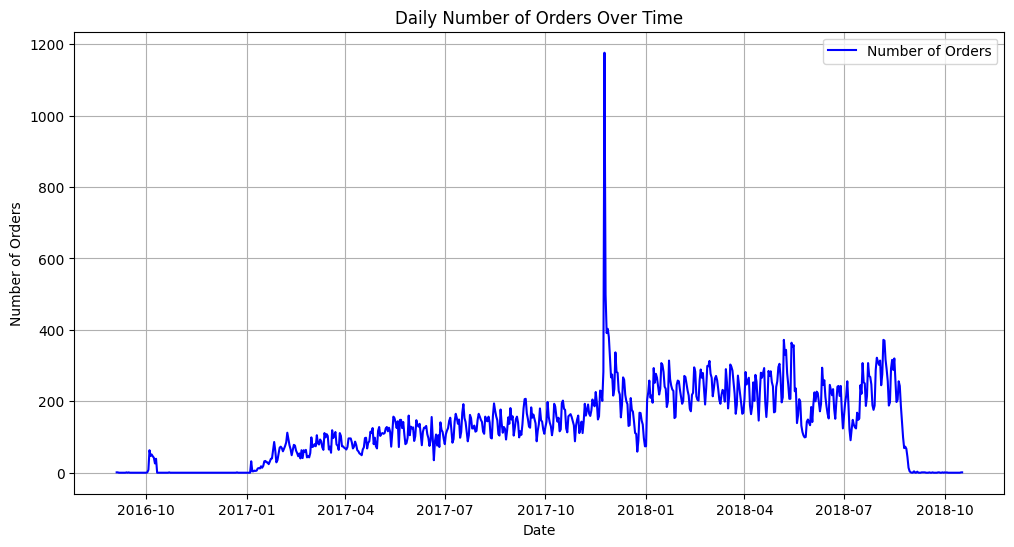

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your dataset
df = pd.read_csv('olist_orders_dataset.csv')

# Convert order_purchase_timestamp to datetime
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

# Resample data to daily frequency and count orders per day
df_daily = df.resample('D', on='order_purchase_timestamp').size()

# Plot the time series data
plt.figure(figsize=(12, 6))
plt.plot(df_daily.index, df_daily.values, label='Number of Orders', color='blue')
plt.title('Daily Number of Orders Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Orders')
plt.legend()
plt.grid(True)

## AD using ADTK (Rules based)

In [9]:
# Load your dataset


import pandas as pd
from adtk.data import validate_series
from adtk.detector import ThresholdAD
df = pd.read_csv('olist_orders_dataset.csv')
df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])

In [10]:
#preprocessing


# Set order_id as the index
df.set_index('order_id', inplace=True)
# Resample data to daily frequency and count orders per day
df_daily = df.resample('D', on='order_purchase_timestamp').size()
# Validate the series for anomaly detection
s = validate_series(df_daily)


In [11]:
threshold_ad = ThresholdAD(high=350, low=50)  # Adjust these values


[<Axes: >]

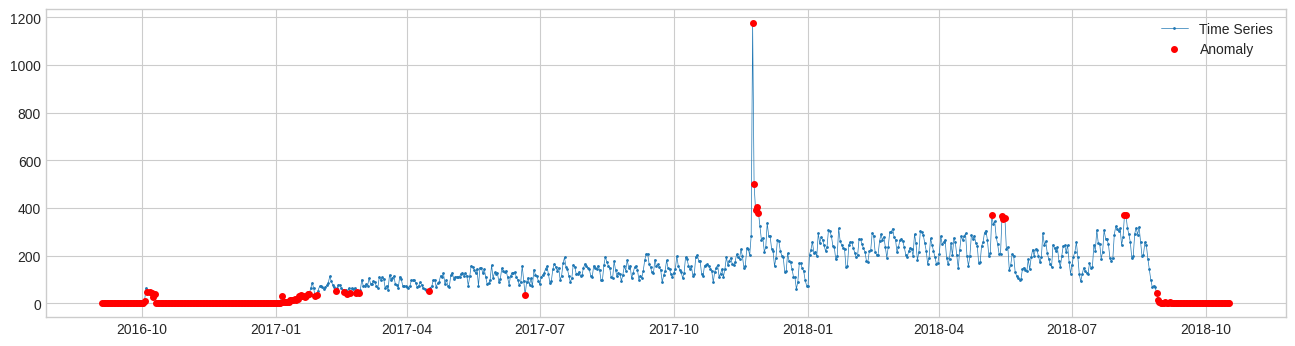

In [12]:
from adtk.visualization import plot
anomalies = threshold_ad.detect(s)
# Plot results
plot(df_daily, anomaly=anomalies, anomaly_color='red', anomaly_tag='marker')

## Using Autogen

### Defining a custom tool where autogen uses

In [13]:
def calculator(date: str) -> str:
    ## PREPROCESSING STARTS
    start_timestamp =  pd.to_datetime(date)
    df = pd.read_csv('olist_orders_dataset.csv')
    df['order_purchase_timestamp'] = pd.to_datetime(df['order_purchase_timestamp'])
    filtered_df = df[(df['order_purchase_timestamp'] >= start_timestamp) &
                     (df['order_purchase_timestamp'] <= '2018-08-28')]
    filtered_df.set_index('order_id', inplace=True)
    df_daily = filtered_df.resample('D', on='order_purchase_timestamp').size()
    s = validate_series(df_daily)
    ## PREPROCESSING ENDS


    ## DETECTING ANOMALIES
    threshold_ad = ThresholdAD(high=350, low=5)
    anomalies = threshold_ad.detect(s)
    anomaly_dates = anomalies[anomalies].index.date

    ##RETURNING DATES AS STRING
    return str(anomaly_dates)


### Defining an agent

In [15]:
import os
os.environ["OPENAI_API_KEY"] = "YOUR_API_KEY"

In [20]:
import os
from autogen import ConversableAgent

# Let's first define the assistant agent that suggests tool calls.
assistant = ConversableAgent(
    name="Assistant",
    system_message="You are a helpful AI assistant. "
    "You can help with analysing anomalies (Order spikes) in the given date. Get the response from calling tool and generate a report in 100 words to let the user know when the order spikes have been occured. Use bullet points. its a must"
    "Return 'TERMINATE' when the task is done.",
    llm_config={"config_list": [{"model": "gpt-4", "api_key": os.environ["OPENAI_API_KEY"]}]},
)


[autogen.oai.client: 10-01 09:33:15] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.


### Defining User proxy agent

In [21]:
# The user proxy agent is used for interacting with the assistant agent
# and executes tool calls.
user_proxy = ConversableAgent(
    name="User",
    llm_config=False,
    is_termination_msg=lambda msg: msg.get("content") is not None and "TERMINATE" in msg["content"],
    human_input_mode="NEVER",
)


### Registering Tool

In [22]:
from autogen import register_function

# Register the calculator function to the two agents.
register_function(
    calculator,
    caller=assistant,  # The assistant agent can suggest calls to the calculator.
    executor=user_proxy,  # The user proxy agent can execute the calculator calls.
    name="anomalydetector",  # By default, the function name is used as the tool name.
    description="detects order spikes from the input user gives",  # A description of the tool.
)


[autogen.oai.client: 10-01 09:33:21] {184} WARNING - The API key specified is not a valid OpenAI format; it won't work with the OpenAI-hosted model.


### Executing Agent

In [23]:
chat_result = user_proxy.initiate_chat(assistant, message="Detect anomaly from April 5 2017")

User (to Assistant):

Detect anomaly from April 5 2017

--------------------------------------------------------------------------------

>>>>>>>> USING AUTO REPLY...
Assistant (to User):

***** Suggested tool call (call_oKAM4nQjkjMDeBtjJ3QVZnzF): anomalydetector *****
Arguments: 
{
  "date": "April 5 2017"
}
********************************************************************************

--------------------------------------------------------------------------------

>>>>>>>> EXECUTING FUNCTION anomalydetector...
User (to Assistant):

User (to Assistant):

***** Response from calling tool (call_oKAM4nQjkjMDeBtjJ3QVZnzF) *****
[datetime.date(2017, 11, 24) datetime.date(2017, 11, 25)
 datetime.date(2017, 11, 26) datetime.date(2017, 11, 27)
 datetime.date(2017, 11, 28) datetime.date(2018, 5, 7)
 datetime.date(2018, 5, 14) datetime.date(2018, 5, 15)
 datetime.date(2018, 5, 16) datetime.date(2018, 8, 6)
 datetime.date(2018, 8, 7)]
*********************************************************

## Improvements?

### Can try and use different libraries
#### Prophet(https://facebook.github.io/prophet/docs/quick_start.html)
#### Isolate Forest Algorithm (SKLearn)
#### Even Try different methods in ADTK